In [30]:
import os
import numpy as np
import tomopy as tp # standard reconstruction algorithms
import wget        # library for URL-downloads
import dxchange    # library fpr opening DX-files (tomographic format)
from numpy.fft import fft, fftshift, ifft, ifftshift, fftn, ifftn
from pynufft import NUFFT
from skimage.transform import iradon_sart
from skimage.transform import iradon
import math
import matplotlib.pyplot as plt

# Образ преобразования Радона

В этом задании вам предлагаются две практические задачи, решение которых оказывается очень удачно опирается на структуру образа преобразования Радона, которая описывается полностью следующей теоремой:

**Теорема. (Гельфанд-Граев-Хелгасон)** Пусть $f\in \mathcal{S}(R^n)$. Тогда $g(s,\theta) = Rf(s,\theta)$ удовлетворяет следующим свойствам:
1. $g\in\mathcal{S}(Z)$
2. $g(s,\theta) = g(-s, -\theta)$
3. для любого $k = 0, 1, \dots$ функции $I_k(\theta)$
\begin{equation}
    I_k(\theta) = \int\limits_{-\infty}^{+\infty}s^k Rf(s,\theta)\, ds, \, \theta \in S^{n-1}.
\end{equation}
являются ограничением однородных полиномов степени $k$ от $\theta_1, \theta_2, \dots, \theta_n$ на сферу $S^{n-1}$. Также если для фуннкции $g(s,\theta)$ выполняются условия (1)-(3), то найдется $f\in \mathcal{S}(R^n)$, такая что $g=Rf$.

## 1. Микротомография (MicroCT) (0.5 балла)

Рентгеновская микротомография (X-ray microtomography, MicroCT) - ещё один раздел рентгеновской томографии, занимающийся
восстановлением изображений структуры маленьких объектов (обычно до нескольких миллиметров в диаметре). 


<table>
<tr>
 <td> <img src="./microct-1.png" alt="micro-ct-1" style="width: 400px;"/> </td>
 <td> <img src="./microct-2.jpg" alt="micro-ct-2" style="width: 300px;"/> </td>
</tr>
<tr>
    <td> снимок радиолярии полученный при помощи MicroCT</td>
    <td> сечение малоберцовой кости мыши</td>
</tr>
</table>



По физической модели и использовании преобразований Радона, микротомография ничем не отличается от обычной рентгеновской. Но есть несколько важных практических отличий:

  * как правило - мишени неживые (если только это не маленькие животные), то есть нет ограничений по 
    дозе облучения, а значит и проблем со статистическим шумом
  * используемый пучок рентгеновских фотонов получают при помощи синхротрона с помощью которого можно гарантировать черезвычайно малую расходимость пучка и более того - оптическую когерентность фотонов (сохранение фазы)
  * излучатель и детектор не вращаются вокруг объекта, вместо этого объект закрепляется на стойке и вращается 
    вокруг своей оси; благодаря этому нет ограничения по шагу дискретизации в лучевых данных
    
Вам предлагается сделать восстановление в задаче микротомографии, где облучаемый объект - человеческий зуб. 

**Задача 1.1** Ввиду такого маленького разрешения возникает следующая проблема: центр вращения объекта на самом деле неизвестен, установить вручную его с точностью порядка разрешающей способности очень тяжело технически. В итоге лучевые данные искажены - центр вращения объекта не соответствует координате 0 по переменной $s$ (см. рисунок). Вам необходимо скорректировать данные и получить изображение сечения зуба (на нём должны быть видны полости и трещины).

Код ниже загружает лучевые данные и переводит в формат `numpy.ndarray`. Ваша задача заключается в том, чтобы восстановить снимок зуба по этим лучевым данным - на нём должна быть видна внутренняя структура зуба и прочие мелкие детали.

Говоря на языке матриц, у нас съехали стоблцы матрицы лучевых данных, то есть по координате $s$ у нас несколько первых столбцов переместились в конец. 

Тогда, можем делать аналогично, чтобы найти правильный вид матрицы лучевых данных. Будем по одному стоблцу перемещать в конец, затем будем проверять, что строка, соответствующая $\theta = 0$ при подстановке в сумму $\sum s_i^k Rf(s_i, \theta = 0)$, тестируемая на нескольких $k$ будет давать $0$ (вернее что-то около нуля), потому что эта сумма соответвует интегралу $\int\limits_{-\infty}^{+\infty}s^k Rf(s,\theta)$, который является полиномом при правильном виде лучевых данных, а значит в нуле он равен нулю.

Тогда, постепенно переставляя столбцы, можно найти наиболее правдоподобный вид матрицы, такой что первая ее строка, соответсвующая $\theta = 0$ будет давать нам $\approx 0$ для суммы $\sum s_i^k Rf(s_i, \theta = 0)$ для наибольшего числа значений $k$.

Так же надо контролировать и свойство $Rf(s, \theta) = Rf(-s, -\theta)$.

In [31]:
# download h5 data with counts data

fname = 'tooth.h5'
data_status = os.path.exists('./' + fname)

if data_status == False:
    url = 'https://raw.github.com/fedor-goncharov/pdo-tomography-course/master/seminar-materials/seminar-3/tooth.h5'
    output_path = './'
    wget.download(url, output_path)

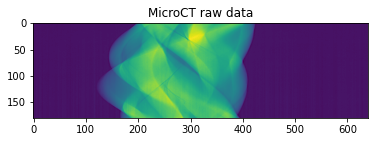

In [32]:
# 1. preprocess data 
proj, flat, dark, theta = dxchange.read_aps_32id(
    fname = fname,
    sino = (0,2),
    )

# 1.1 normalize projection data and take -log
proj = tp.normalize(proj, flat, dark)
proj = tp.minus_log(proj)

# 1.2 convert to numpy.ndarray of size 181 x 640
proj_vis = np.reshape(proj[:, 0, :], (181, 640))

# 1.3 (optional) plot image of raw data
plt.imshow(proj_vis)
plt.title('MicroCT raw data')
plt.show()

Мы хотим получить свойство для матрицы $R(s, \theta) = R(-s, -\theta)$. Знаем, что $\theta = (cos \phi, sin \phi)$. Значит, нам нужны данные для $\theta$ и $-\theta$. Но мы в верхней полуокружности, то есть на $(0, \pi)$. Значит, получить отрицательный синус мы не можем, просто мы не сможем проверить выполнение свойства так как не обладаем достаточным количеством информации. Тогда можем проверить выполнение свойства только на $sin \phi = 0$, то есть на $\phi = 0$ и $\phi = \pi$. Тогда нам надо проверить совпадение (в матричном случае близость) элементов матрицы $R[i][0] = R[nshift - i][ntheta]$. 

In [33]:
proj_swaped = proj_vis

m = 10
eps2 = 0.4
eps3 = 0.04
nshift = 640
ntheta = 181
shifts = np.linspace(-1, 1, nshift)
deltashift = 2.0/nshift
summas = np.zeros((m, nshift))

indicator2 = 0
indicator3 = 0

print("Значения сдвигов, для которых почти выполнено свойство 2.")

for i in range(nshift):
    proj_swaped = np.concatenate((proj_swaped[:, 1:], proj_swaped[:, :1]), axis=1)

    indicator2 = 0

    for j in range(nshift):
        if (np.abs(proj_swaped[0][j] - proj_swaped[ntheta-1][nshift-1-j]) < eps2):
            indicator2 += 1
    
    if (indicator2 == nshift):
        print(i)


print("Значения сдвигов, для которых почти выполнено свойство 3.")

for i in range(nshift):
    proj_swaped = np.concatenate((proj_swaped[:, 1:], proj_swaped[:, :1]), axis=1)

    for h in range(m):
        sum = 0
        for j in range(nshift):
            sum += deltashift*np.power(shifts[j], h)*proj_swaped[0][j]
        summas[h][i] = sum

    for j in range(nshift):
        indicator3 = 0
        for h in range(m):
            if (np.abs(summas[h][i]) < eps3):
                indicator3 += 1

    if (indicator3 == m-1):
        print(i)

Значения сдвигов, для которых почти выполнено свойство 2.
294
295
296
614
615
616
Значения сдвигов, для которых почти выполнено свойство 3.
0
1
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639


Оба свойства почти выполнены на сдвигах 614, 615, 616. 
Кусок кода ниже ищет центр через tomopy, что соответствует сдвигу 616. То есть правильное значение мы нашли.

s-center  296
Размер сдвига, подаваемый алгоритму  616


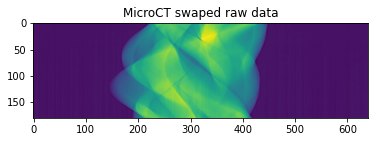

In [34]:
s = int(tp.find_center(proj, theta, init=320, ind=0, tol=0.5))
print("s-center ", s)

n = nshift + s - nshift//2

print("Размер сдвига, подаваемый алгоритму ", n)

proj_swaped = np.concatenate((proj_vis[:, n:], proj_vis[:, :n]), axis=1)

plt.imshow(proj_swaped)
plt.title('MicroCT swaped raw data')
plt.show()

Проверим правильность размера сдвига по алгоритму, который я описала раньше. Проверим, что сумма, соответствующая интегралу при $\theta = 0$ примерно равна $0$ для нескольких значений $k$.

In [35]:
m = 10
nshift = 640
shifts = np.linspace(-1, 1, nshift)
deltashift = 2.0/nshift
for i in range(m):
    sum = 0
    for j in range(nshift):
        sum += deltashift*np.power(shifts[j], i)*proj_swaped[0][j]
    print(sum)


0.8981292775091838
0.03288575209689183
0.03698829670504669
0.0037854027804563044
0.0037835249177764147
0.00045006462206222906
0.0010089385706415822
4.981535829864248e-05
0.0005654533097318945
1.4901977926980485e-06


Видим, что суммы, соответствующие интегралу для первых 10 $k$ (можно было и дальше выводить) примерно равны 0 (на первое число можно не смотреть, оно по понятным причинам будет оданоково для любой перестановки столбцов, так как это просто сумма строки матрицы Радона), то есть сдвиг выбран правильный, потому что тогда условие 3 в теореме выполнено. Теперь можно восстанавливать изображение.

Посмотрим, какое восстановление должно получаться с помощью библиотеки tomopy.

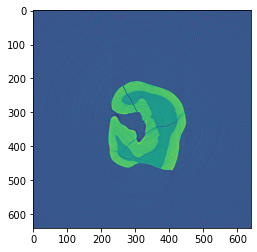

In [36]:
reconstruction = tp.recon(proj, theta, center=s, algorithm='gridrec')
plt.imshow(reconstruction[0, :,:])
plt.show()

А теперь нарисуем, что получилось у меня по методу из предыдущей домашки с помощью библиотеки pynufft.

In [37]:
def fouriereconstruction(ntheta, nshift, proj_swaped):
  shifts = np.linspace(-1, 1, nshift)
  theta = np.linspace(0, np.pi, ntheta, endpoint = False)

  fourieprojection = []

  for i in range(ntheta):
    fourieprojection.append(fftshift(fft(ifftshift(proj_swaped[i]))))

  for i in range(nshift):
    for j in range(ntheta):
      fourieprojection[j][i] = fourieprojection[j][i] * np.abs(shifts[i])

  fourieprojection = np.reshape(fourieprojection, (ntheta*nshift, 1))

  from pynufft import NUFFT

  om = np.zeros((ntheta*nshift, 2))

  for j in range(nshift):
    for i in range(ntheta):
      om[i*nshift + j][0] = shifts[j] * np.sin(theta[i])
      om[i*nshift + j][1] = shifts[j] * np.cos(theta[i])


  NufftObj = NUFFT()

  Nd = (1024, 1024)  # image size
  print('setting image dimension Nd...', Nd)
  Kd = (2048, 2048)  # k-space size
  print('setting spectrum dimension Kd...', Kd)
  Jd = (6, 6)  # interpolation size
  print('setting interpolation size Jd...', Jd)

  NufftObj.plan(om, Nd, Kd, Jd)

  image = NufftObj.adjoint(fourieprojection)

  fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
  im = axs.imshow(np.abs(image))
  axs.set_title('Tooth')
  plt.show()

setting image dimension Nd... (1024, 1024)
setting spectrum dimension Kd... (2048, 2048)
setting interpolation size Jd... (6, 6)


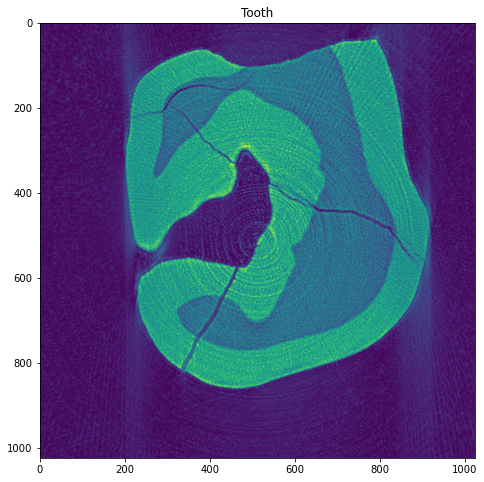

In [38]:
ntheta = 181
nshift = 640
fouriereconstruction(ntheta, nshift, proj_swaped)

Отлично видны контуры, углубления и трещины. Значит, данные я сдвинула верно и восстановление корректное.

Про некоторую неопределенность в сдвиге, нам подошли сдвиги 614, 615, 616. Честно было проверено, что и 614, и 615 тоже неплохо подойдут. Ниже приведу доказательство. 

setting image dimension Nd... (1024, 1024)
setting spectrum dimension Kd... (2048, 2048)
setting interpolation size Jd... (6, 6)


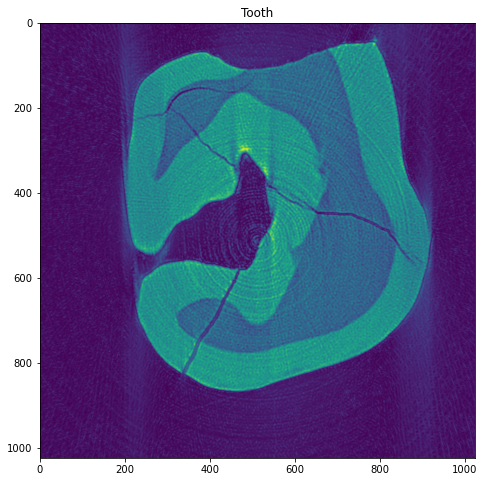

In [39]:
n = 614
proj_swaped = np.concatenate((proj_vis[:, n:], proj_vis[:, :n]), axis=1)
fouriereconstruction(ntheta, nshift, proj_swaped)

setting image dimension Nd... (1024, 1024)
setting spectrum dimension Kd... (2048, 2048)
setting interpolation size Jd... (6, 6)


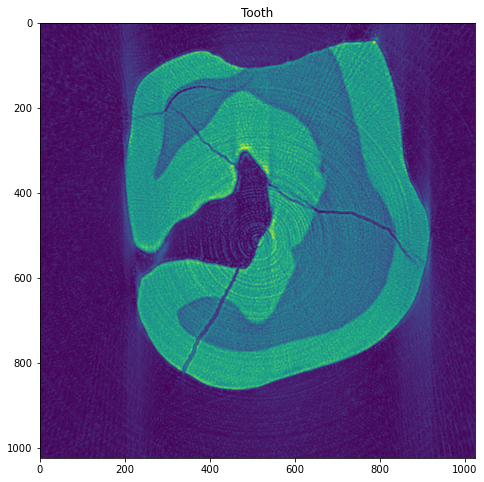

In [40]:
n = 615
proj_swaped = np.concatenate((proj_vis[:, n:], proj_vis[:, :n]), axis=1)
fouriereconstruction(ntheta, nshift, proj_swaped)

## 2. Формулы Гончарова в электронной микроскопии (0.5 балла)

В электронной микроскопии исследуемые объекты имеют размеры существенно меньше чем в случае MicroCT (порядка микрометров и меньше). Облучение объекта идет пучком электронов, тем не менее, в некоторых моделях исходные данные можно моделировать классическими преобразованиями Радона. 

<img src="./microscope.png" alt="micro-ct-1" style="width: 400px;"/>

Возникает следующая практическая проблема:
 * исследуемый объект невозможно "вращать" ввиду его малости (например бактерия или клетка). Можно считать, что  объект находится в некоторой среде и случайно поворачивается, поэтому в различные времена микроскоп получает данные для разных направлений $Rf(s,\theta_i), \, \theta_1, \theta_2, \dots, \theta_n$, другое дело, что сами $\theta_i$ - **неизвестны**. 
 
Поэтому:
 1. Из лучевых  данных $Rf(s,\theta_i), \, \theta_1, \theta_2, \dots, \theta_n$ требуется восстановить направления $\theta_i$ (хотя бы с точностью до общего поворота). 
 2. Восстановить объект по лучевым данным $Rf(s,\theta_i), \, \theta_1, \theta_2, \dots, \theta_n$, используя подходящий алгоритм восстановления. 
 
Алгоритм восстановления $\{\theta_i\}_{i=1}^n$ следующий: 

1. $\theta_i = (\cos\varphi, \sin\varphi), \, \varphi \in [0, \pi)$, поэтому достаточно восстановить $\{\varphi_i\}_{i=1}^n$ с точностью до общего поворота. Определим моменты 
\begin{equation}
    I_k(\varphi) = \int\limits_{-\infty}^{+\infty}s^k Rf(s,\theta(\varphi))\, ds, \, k = 0, 1, \dots
\end{equation}
2. Несложно показать, что моменты $I_1(\varphi)$, $I_2(\varphi)$ можно представить в следующем виде (можете доказать, если это неочевидно)
\begin{equation}
    I_1(\varphi) = a \cos(\varphi - \alpha), \, I_2(\varphi) = b\cos(2\varphi-\beta) + c.
\end{equation}
Рассмотрим кривую $\Gamma$ на плоскости $R^2$ которая задаётся парметрически следующим образом:
\begin{align}
    \Gamma = \{x(\varphi), y(\varphi) | x(\varphi) = I_1(\varphi), \, y(\varphi) = I_2(\varphi), \, \varphi \in [0, 2\pi] \}
\end{align}

**Определение 1.** Кривая $\Gamma$ на $R^2$ называется алгебраической порядка $k$, если множество её точек $(x,y)\in \Gamma$ представимо в виде решения уравнения 
\begin{equation}
    P(x,y) = 0,
\end{equation}
где 
\begin{equation}
    P \text{ - однородный полином от двух переменных степени }k. 
\end{equation}

**Лемма 1.** Кривая $\Gamma$ определённая выше является алгебраической кривой степени 4. 
 
3. Однородный полином степени $4$ определяется своими $15$-ую коэффициентами. Восстановите кривую $\Gamma$ (коэффициенты соответствующего полинома) из лучевых данных (даже если мы и не знаем углы), если учесть, что лучевые данные содержат 15 направлений.

4. Чтобы восстановить a, b, c, которые входят в параметризацию $I_1(\varphi)$, $I_2(\varphi)$ воспользуемся формулами (проверьте их)
\begin{equation}
    a = (x_{max} - x_{min})/2, \, b = (y_{max} - y_{min})/2, \, c = (y_{max} + y_{min})/2, 
\end{equation}
где $x_{max}, x_{min}$, $y_{min}$, $y_{max}$, точки принадлежащие кривой $\Gamma$.

5. Из условия, что $\{\varphi_{i}\}_{i=1}^n$ необходимо восстановить до общего поворота, будем считать, что 
\begin{equation}
    \varphi_1 = 0.
\end{equation}
Из набора данных $\cos(\alpha), \, \cos(\beta), \cos(\varphi_i-\alpha), \, \cos(2\varphi_i - \beta)$ можно восстановить все углы $\varphi_i$, $i = 1, 2, \dots, 15$.


Будем рассматривать полином вида $\alpha_1 x^4 + \alpha_2 x^3y + \alpha_3 x^2 y^2 + \alpha_4 xy^3 + \alpha_5 y^4 + \alpha_6 x^3 + \alpha_7 x^2 y + \alpha_8 xy^2 + \alpha_9 y^3 + \alpha_{10} x^2 + \alpha_{11} xy + \alpha_{12} y^2 + \alpha_{13} x + \alpha_{14} y - 1$, то есть полином с нормированными коэффициентами. 

Удвоим лучевые данные, учитывая, что $R(s, \theta) = R(-s, -\theta)$.

В результате для $I_1$ получим за счет умножения на $s$, что $I_1(\theta) = \int\limits_{-\infty}^{+\infty}s Rf(s,\theta(\varphi)) ds = \int\limits_{-\infty}^{+\infty}s Rf(-s,-\theta(\varphi)) ds = \int\limits_{+\infty}^{-\infty}(-s) Rf(s,-\theta(\varphi)) d(-s) = \int\limits_{+\infty}^{-\infty}s Rf(s,-\theta(\varphi)) ds = - \int\limits_{-\infty}^{+\infty}s Rf(s,-\theta(\varphi)) ds = I_1(-\theta)$

Для $I_2$ получим за счет умножения на $s^2$, что $I_2(\theta) = \int\limits_{-\infty}^{+\infty}s^2 Rf(s,\theta(\varphi)) ds = \int\limits_{-\infty}^{+\infty}s^2 Rf(-s,-\theta(\varphi)) ds = \int\limits_{+\infty}^{-\infty}(-s)^2 Rf(s,-\theta(\varphi)) d(-s) = -\int\limits_{+\infty}^{-\infty}s^2 Rf(s,-\theta(\varphi)) ds = \int\limits_{-\infty}^{+\infty}s^2 Rf(s,-\theta(\varphi)) ds = I_2(-\theta)$

В итоге добавляем еще 15 лучевых данных, теперь вырожденную систему будет возможно корректно разрешить.

Решать будем с помощью МНК. Находим все коэффициенты кривой, строим ее. Затем из условий $a = (x_{max} - x_{min})/2, \, b = (y_{max} - y_{min})/2, \, c = (y_{max} + y_{min})/2$ находим эти коэффициенты. 

Теперь будем искать углы $\phi_i$, а потом подадим их на вход функции для восстановления изображения.

$I_1(\varphi) = a \cos(\varphi - \alpha), \, I_2(\varphi) = b\cos(2\varphi-\beta) + c$

$I_1(\varphi)/a = \cos\varphi\cos\alpha + \sin\varphi\sin\alpha , \, (I_2(\varphi) - c)/b  = \cos 2\varphi \cos\beta + \sin 2\varphi \sin\beta$

$I_1(\varphi)/a - \cos\varphi\cos\alpha = \sin\varphi\sin\alpha , \, (I_2(\varphi) - c)/b - \cos 2\varphi \cos\beta = \sin 2\varphi \sin\beta$

$(I_1(\varphi)/a - \cos\varphi\cos\alpha)/\sin\alpha = \sin\varphi , \, ((I_2(\varphi) - c)/b - \cos 2\varphi \cos\beta)/(2\cos\varphi\sin\beta) = \sin \varphi$

$\frac{\frac{I_1}{a} - \cos\varphi\cos\alpha}{\sin\alpha} = \frac{\frac{I_2 - c}{b} - \cos 2\varphi \cos\beta}{2\cos\varphi\sin\beta}$

$(\frac{I_1}{a} - \cos\varphi\cos\alpha)(2\cos\varphi\sin\beta) = (\frac{I_2 - c}{b} - \cos 2\varphi \cos\beta)(\sin\alpha)$

$(-2\cos\alpha\sin\beta) \cos^2\varphi + (2\sin\beta\frac{I_1}{a})\cos\varphi = \sin\alpha\frac{I_2 - c}{b} - (\sin\alpha\cos\beta)(2\cos^2\varphi - 1)$

$(2\sin\alpha\cos\beta - 2\cos\alpha\sin\beta)\cos^2\varphi + (2\sin\beta\frac{I_1}{a})\cos\varphi - \sin\alpha\frac{I_2 - c}{b} + \sin\alpha\cos\beta = 0$


**Задача 2.1** Используйте алгоритм выше для того, чтобы найти направления 15-и неизвестных проекций. Код ниже загружаен лучевые данные с сервера.

In [41]:
# download h5 data with counts data

fname = 'microscope-data.bin'
data_status = os.path.exists('./' + fname)

if data_status == False:
    url = 'https://raw.github.com/fedor-goncharov/pdo-tomography-course/master/seminar-materials/seminar-3/' + fname
    output_path = './'
    wget.download(url, output_path)

C:\Users\Sveta\AppData\Local\Temp\ipykernel_100600\2804404250.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  projections_exterior_data = np.reshape(np.fromfile(fname, dtype=np.float), (ntheta, nshift))


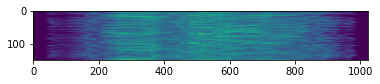

In [42]:
nshift = 1024
ntheta = 150

projections_exterior_data = np.reshape(np.fromfile(fname, dtype=np.float), (ntheta, nshift))
plt.imshow(projections_exterior_data) # show unordered projection data

In [43]:
def func(coefisients, x, y):
    res = np.zeros(14)
    res[0] = coefisients[0]*x
    res[1] = coefisients[1]*y
    res[2] = coefisients[2]*x**2
    res[3] = coefisients[3]*y**2
    res[4] = coefisients[4]*x*y
    res[5] = coefisients[5]*x**3
    res[6] = coefisients[6]*y**3
    res[7] = coefisients[7]*x**2*y
    res[8] = coefisients[8]*x*y**2
    res[9] = coefisients[9]*x**4
    res[10] = coefisients[10]*y**4
    res[11] = coefisients[11]*x**3*y
    res[12] = coefisients[12]*x**2*y**2
    res[13] = coefisients[13]*x*y**3
    return res


Найденные коэффициенты кривой  [ 1.21920153e-12  1.71924763e+01 -3.48532423e+02 -6.92867356e+01
 -2.44213538e-11  1.12756221e-10 -3.52449390e+01  4.39893376e+03
  1.52650337e-10 -1.74569221e+05 -4.39580677e+01 -6.00308112e-10
  1.54209492e+03 -3.03507219e-10]


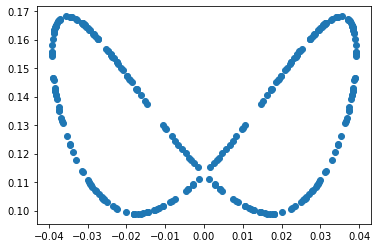

In [44]:
I1 = np.zeros(300)
I2 = np.zeros(300)
deltashift = 2.0/nshift
for i in range(150):
    for j in range(nshift):
        s = -1.0 + j*deltashift
        I1[i] += deltashift*s*projections_exterior_data[i][j]
        I2[i] += deltashift*s*s*projections_exterior_data[i][j]

for i in range(150, 300):
    I1[i] = -I1[i-150]
    I2[i] = I2[i-150]

matr = np.zeros((300, 14))
for i in range(300):
    matr[i] = func(np.ones(14), I1[i], I2[i])

plt.scatter(I1, I2)

coefisients = np.linalg.lstsq(matr, np.ones(300), rcond = -1)[0]
print("Найденные коэффициенты кривой ", coefisients)

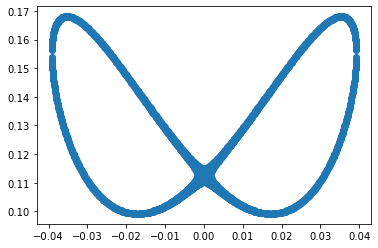

In [45]:
eps = 0.0005
n = 1000
x = np.linspace(-0.05, 0.05, n)
y = np.linspace(0, 0.2, n)
pointsx = []
pointsy = []

for i in range(n):
    for j in range(n):
        if (np.abs(np.sum(func(coefisients, x[i], y[j]))-1) <= eps):
            pointsx.append(x[i])
            pointsy.append(y[j])

plt.scatter(pointsx, pointsy)

In [46]:
a = (max(pointsx) - min(pointsx))/2
b = (max(pointsy) - min(pointsy))/2
c = (max(pointsy) + min(pointsy))/2

print("a = ", a)
print("b = ", b)
print("c = ", c)

cosalpha = I1[0]/a
cosbeta = (I2[0] - c)/b
sinalpha = math.sqrt(1 - np.power(cosalpha, 2))
sinbeta = -math.sqrt(1 - np.power(cosbeta, 2))

alpha = np.arccos(I1[0]/a)
beta = np.arccos((I2[0]-c)/b)

print("alpha = ", alpha)
print("beta = ", beta)

a =  0.03918918918918919
b =  0.03453453453453454
c =  0.13363363363363365
alpha =  0.5836857530673698
beta =  0.2640451897929331


In [47]:
eps = 0.0005
phi = []
n = 10000
phitest = np.linspace(0, 2*np.pi, n)

for j in range(150):
    for i in range(n):
        if ((np.abs(a*np.cos(phitest[i] - alpha) - I1[j]) < eps) and (np.abs(b*np.cos(2*phitest[i] - beta) + c - I2[j]) < eps)):
            phi.append(phitest[i])
            break

print("Количество найденных направлений ", len(phi))

Количество найденных направлений  150


## Итеративный метод ART для произвольной геометрии сканирования


Пусть необходимо решить линейную систему:
\begin{equation}
    Af = g, \, A\in \mathrm{Mat}(d, p), \, f\in R^p, \, g\in R^d.
\end{equation}

Пусть также $f_k$ - текущая аппроксимация $f$. Тогда обновить $f_k$ можно ортогонально спроецировав его на афинную плоскость 

\begin{equation}
    a_i^Tf = g_i, \, i\in \{1, \dots, d\}.
\end{equation}

Обозначим через $P_i$ - оператор ортогональной проекции на гиперплоскость $a_i^Tf = g_i$. Тогда алгоритм ART можно записать через следующий псевдокод:

```
    Algorithm ART
    
    set k=0, f(0) be the initial point
    repeat until convergence (set stopping criterion)
    
        u(0) := f(k)
        for n in (0, ..., d-1) do
            u(n+1) := Pn * u(n)
        endfor     
        f(k+1) := u(d)
        k := k + 1
        
    endrepeat
    
```


**Задача 2.2** Используйте алгоритм ART (или любой другой, подходящий для решения данной линейной сиситемы) для того чтобы из полученных данных восстановить исходное изображение. *Подсказка:* для работы алгоритма ART вам необходимо уметь вычислять строку матрицы преобразования Радона - для этого можете использовать код из первой лекции, либо код предоставленный лектором `line_projector_siddon`, который интегрирует точно изображение вдоль линии. Также вам необходимо самостоятельно найти форму проектора $P_i$. 

**Параметры:** исходное изображение имело размер 256x256,  15 случайных проекций, 1024 луча в каждой проекции равномерно распределённых на отрезке [-1, 1]

In [48]:
# npixels - pixels per image dimension, N x N = npixels x npixels
# ntheta  - number of projections
# nshifts - number of lines per projection

ntheta = 150
nshift = 1024
npixels = 64

def matrixradon2d(npixels, ntheta, nshift, phir, radius=1.0):
    
    radon_matrix = np.zeros((ntheta*nshift, npixels**2))
    
    #1. init geometry/sizes  
    dx = 2.0 * radius / npixels # pixel's sidelength
    shifts = np.linspace(-radius + dx/2, radius-dx/2, nshift)
    theta = phir
    
    # 2. YOUR CODE HERE
    for i_pixel in range(npixels**2):
        
        # 2.1 pixel's coordinates
        pixel_coords = np.array([-radius + dx/2 + dx*(i_pixel % npixels),  
                                  radius - dx/2 - dx*(i_pixel // npixels)])
        
        # 2.2 create one-pixel image 
        image = np.zeros(npixels**2)
        image[i_pixel] = 1.0
        image = np.reshape(image, (npixels, npixels))
    
        # 2.3 compute matrix projection vector 
        proj_vector = np.zeros((ntheta, nshift))
        
        for i_theta in range(ntheta):
            # 2.4 find shifts that are needed for computation for the pixel, others are 0's
              phi = theta[i_theta]

              s = pixel_coords[0]*np.cos(phi) + pixel_coords[1]*np.sin(phi)
              i_shift = int( nshift*(1+s)/2)
              if (i_shift >= nshift or i_shift < 0):
                break

              if (phi == 0 or phi == np.pi or phi == 2*np.pi or phi == np.pi/2 or phi == 3*np.pi/2):
                  phi += 0.001

              ind1 = False
              ind2 = False
              ind3 = False
              ind4 = False

              res = 0
              tau = math.sqrt(2-s**2)

              x = pixel_coords[0] - dx/2
              t = (s*np.cos(phi) - x) / np.sin(phi)
              y = s*np.sin(phi) + t*np.cos(phi)
              if (y <= pixel_coords[1]+dx/2 and y >= pixel_coords[1]-dx/2 and t >= -tau and t <= tau):
                  t1 = t
                  ind1 = True

              x = pixel_coords[0] + dx/2
              t = (s*np.cos(phi) - x) / np.sin(phi)
              y = s*np.sin(phi) + t*np.cos(phi)
              if (y <= pixel_coords[1]+dx/2 and y >= pixel_coords[1]-dx/2 and t >= -tau and t <= tau):
                   t2 = t
                   ind2 = True

              y = pixel_coords[1] - dx/2
              t = (y - s*np.sin(phi)) / np.cos(phi)
              x = s*np.cos(phi) - t*np.sin(phi)
              if (x <= pixel_coords[0]+dx/2 and x >= pixel_coords[0]-dx/2 and t >= -tau and t <= tau):
                  t3 = t
                  ind3 = True

              y = pixel_coords[1] + dx/2
              t = (y - s*np.sin(phi)) / np.cos(phi)
              x = s*np.cos(phi) - t*np.sin(phi)
              if (x <= pixel_coords[0]+dx/2 and x >= pixel_coords[0]-dx/2 and t >= -tau and t <= tau):
                t4 = t
                ind4 = True
                
              if (ind1 == True and ind2 == True):
                res = np.abs(t2 - t1)
              if (ind1 == True and ind3 == True):
                res = np.abs(t3 - t1)
              if (ind1 == True and ind4 == True):
                res = np.abs(t4 - t1)
              if (ind2 == True and ind3 == True):
                res = np.abs(t3 - t2)
              if (ind2 == True and ind4 == True):
                res = np.abs(t4 - t2)
              if (ind3 == True and ind4 == True):
                res = np.abs(t4 - t3)

              if (res != 0):
                proj_vector[i_theta][i_shift] = res
            
        # return column
        radon_matrix[:, i_pixel] = np.reshape(proj_vector, ntheta*nshift)
    
    return radon_matrix

radon2d_matrix = matrixradon2d(npixels, ntheta, nshift, phi, radius=1.0)

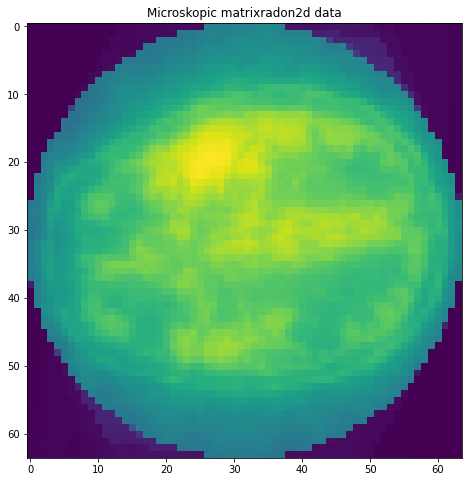

In [49]:
adjradon2d_matrix = np.transpose(radon2d_matrix)

normal_phantom = np.dot(adjradon2d_matrix, np.reshape(projections_exterior_data, (ntheta*nshift, 1)))

fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
axs.imshow(np.reshape(normal_phantom, (npixels, npixels)))
axs.set_title('Microskopic matrixradon2d data')
plt.show() 

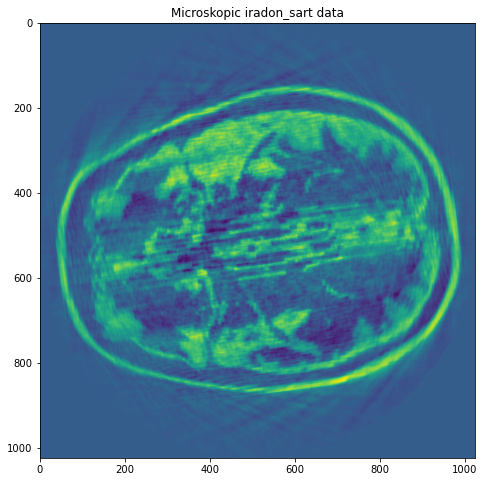

In [50]:
radius = 1.0
npixels = 128

phigrad = np.zeros(ntheta)
for i in range(ntheta):
    phigrad[i] = phi[i] / np.pi * 180

phantom = iradon_sart(np.transpose(projections_exterior_data), theta = phigrad, image=None, projection_shifts=None,
                clip=None, relaxation=0.3, dtype=None)
fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
axs.imshow(phantom)
axs.set_title('Microskopic iradon_sart data')
plt.show() 

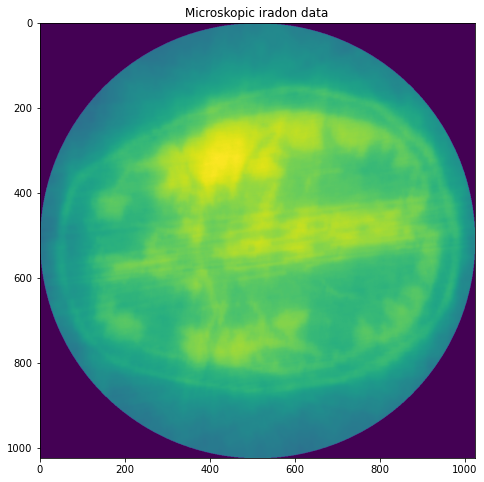

In [51]:
phantom = iradon(np.transpose(projections_exterior_data), theta = phigrad, output_size=None, filter_name=None, interpolation='linear', circle=True, preserve_range=True)
fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharey=True)
axs.imshow(phantom)
axs.set_title('Microskopic iradon data')
plt.show() 